In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
import sys
sys.path.append("../scripts")

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [147]:
plt.rcParams["figure.figsize"] = (14,6)

In [148]:
obs = pd.read_csv("../data/obs_arg.csv", parse_dates=["date"])
obs = obs.set_index("date")
obs = obs.drop(columns=["Total_Confirmed"])
obs

,I,R,D
date,,,
2020-03-03,1,0,0
2020-03-04,1,0,0
2020-03-05,1,0,0
2020-03-06,2,0,0
2020-03-07,8,0,0
...,...,...,...
2020-06-05,14317,6088,632
2020-06-06,15192,6180,648
2020-06-07,15221,6909,664


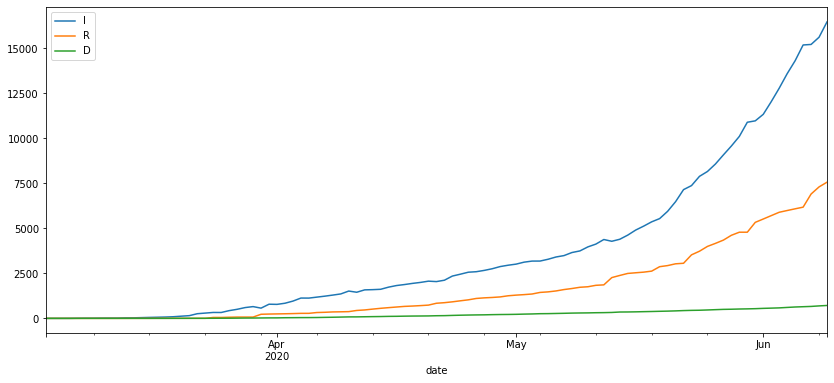

In [149]:
obs.plot()

In [150]:
obs = obs.rolling(window=7, min_periods=1).mean()

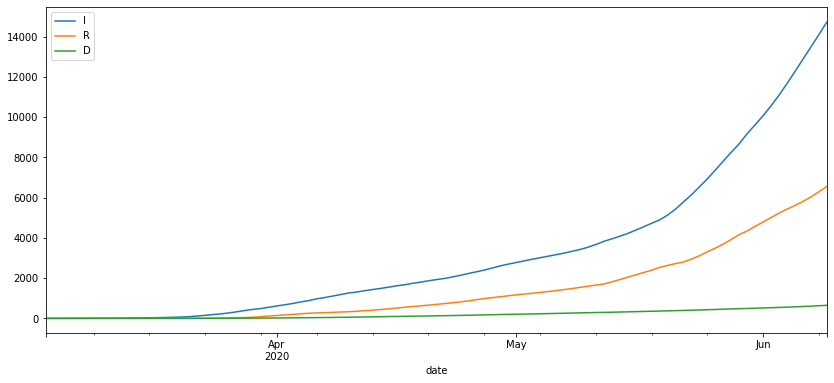

In [151]:
obs.plot()

In [152]:
def train_test_split(data, split, start=None, end=None):
    if start is None:
        start = data.index[0]
    if end is None:
        end = data.index[-1]
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    split = pd.to_datetime(split)
    one = pd.DateOffset(days=1)
    train = data[start:split-one].copy()
    test = data[split:end].copy()
    return train, test

In [153]:
data_start = "2020-04-01"
data_split = "2020-06-01"
train, test = train_test_split(obs, split=data_split, start=data_start)

In [154]:
train

,I,R,D
date,,,
2020-04-01,617.428571,142.142857,19.571429
2020-04-02,676.142857,169.714286,23.428571
2020-04-03,741.285714,197.428571,27.142857
2020-04-04,816.857143,227.000000,30.714286
2020-04-05,884.428571,256.714286,34.285714
...,...,...,...
2020-05-27,7818.571429,3695.857143,456.714286
2020-05-28,8260.571429,3922.285714,469.857143
2020-05-29,8683.000000,4168.857143,482.285714


In [155]:
test

,I,R,D
date,,,
2020-06-01,10080.142857,4795.142857,519.285714
2020-06-02,10575.000000,5015.428571,531.428571
2020-06-03,11104.285714,5236.428571,543.285714
2020-06-04,11678.428571,5433.000000,557.571429
2020-06-05,12279.285714,5618.714286,573.571429
2020-06-06,12892.714286,5817.571429,590.714286
2020-06-07,13499.142857,6042.285714,608.571429
2020-06-08,14111.142857,6297.142857,628.142857
2020-06-09,14744.714286,6562.714286,649.285714


## SIR

In [156]:
from SEIR import SIR

In [157]:
init_I, init_R, init_D = train.head(1).to_numpy().flatten()

In [158]:
model = SIR(population=44e6, init_infected=init_I, init_recovered=init_R, init_dead=init_D)

In [159]:
model.fit(train, estimate=('r_transmission', "r_recovery", "r_mortality"), 
          method="Nelder-Mead", options={"maxiter": 5000})

 final_simplex: (array([[0.07090355, 0.02272974, 0.00309915],
       [0.07090355, 0.02272974, 0.00309914],
       [0.07090353, 0.02272974, 0.00309913],
       [0.07090353, 0.02272973, 0.00309913]]), array([6550337.37262442, 6550337.37262481, 6550337.37263114,
       6550337.37270483]))
           fun: 6550337.372624419
       message: 'Optimization terminated successfully.'
          nfev: 265
           nit: 144
        status: 0
       success: True
             x: array([0.07090355, 0.02272974, 0.00309915])

In [160]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

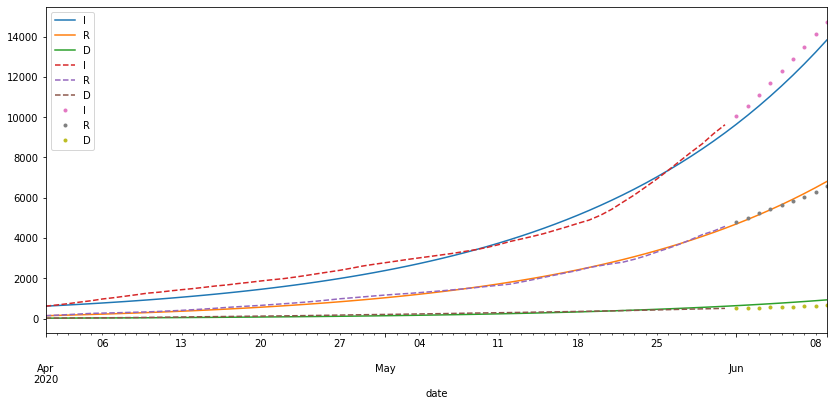

In [161]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")

## SEIR

In [162]:
from SEIR import SEIR

In [163]:
model = SEIR(population=44e6, init_infected=init_I, init_recovered=init_R, init_dead=init_D, init_exposed=500)

In [164]:
model.fit(train, estimate=('r_transmission', "r_progression", "r_recovery", "r_mortality"),
          method="Nelder-Mead", options={"maxiter": 5000})

 final_simplex: (array([[0.08424779, 0.02144885, 0.14726334, 0.00293826],
       [0.08424783, 0.02144884, 0.14726301, 0.00293825],
       [0.08424772, 0.02144884, 0.14726352, 0.00293825],
       [0.08424773, 0.02144884, 0.14726341, 0.00293824],
       [0.08424773, 0.02144883, 0.14726345, 0.00293826]]), array([5165532.68703354, 5165532.68703807, 5165532.68705483,
       5165532.68711347, 5165532.68713057]))
           fun: 5165532.687033537
       message: 'Optimization terminated successfully.'
          nfev: 793
           nit: 478
        status: 0
       success: True
             x: array([0.08424779, 0.02144885, 0.14726334, 0.00293826])

In [165]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

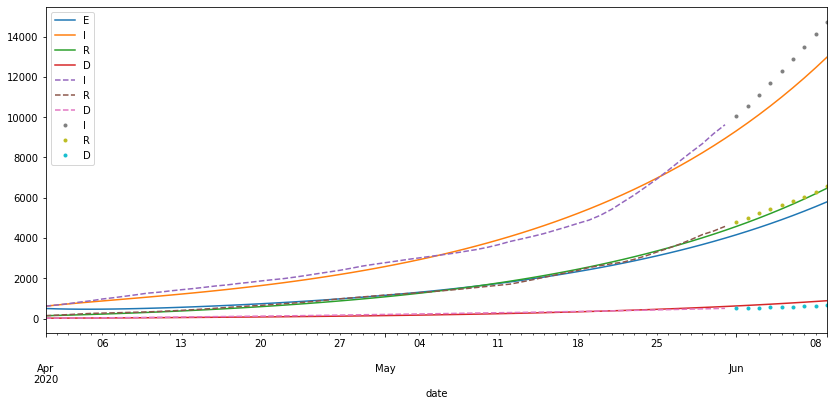

In [166]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")

## SEIRH

In [167]:
from SEIR import SEIRH

In [168]:
model = SEIRH(init_infected=init_I, init_recovered=init_R, init_dead=init_D, 
              init_exposed=1000, init_hospitalized=100,
              r_hospitalized=0.05, r_recovery_hosp=0.01, r_recovery_mild=0.1)

In [169]:
model.fit(train, estimate=('r_transmission', "r_progression", "r_mortality", 
                           "r_hospitalized", "r_recovery_hosp", "r_recovery_mild"), 
          method="Nelder-Mead", options={"maxiter": 10000})

 final_simplex: (array([[ 1.53047407e-01,  2.15572068e-02,  3.86711613e-03,
         9.72831244e-02, -1.00706254e-04,  4.42562556e-02],
       [ 1.53047631e-01,  2.15573649e-02,  3.86710530e-03,
         9.72830841e-02, -1.00907048e-04,  4.42562195e-02],
       [ 1.53047898e-01,  2.15572708e-02,  3.86709847e-03,
         9.72830247e-02, -1.00781289e-04,  4.42564477e-02],
       [ 1.53047474e-01,  2.15571944e-02,  3.86710854e-03,
         9.72831066e-02, -1.00693108e-04,  4.42563007e-02],
       [ 1.53047864e-01,  2.15572870e-02,  3.86710239e-03,
         9.72830364e-02, -1.00802899e-04,  4.42564130e-02],
       [ 1.53047615e-01,  2.15572020e-02,  3.86711242e-03,
         9.72830677e-02, -1.00676065e-04,  4.42563739e-02],
       [ 1.53047628e-01,  2.15572179e-02,  3.86711792e-03,
         9.72830875e-02, -1.00717849e-04,  4.42563735e-02]]), array([5318536.16716272, 5318536.16718198, 5318536.16718319,
       5318536.16718488, 5318536.16719658, 5318536.16720488,
       5318536.1672572 ]))

In [170]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

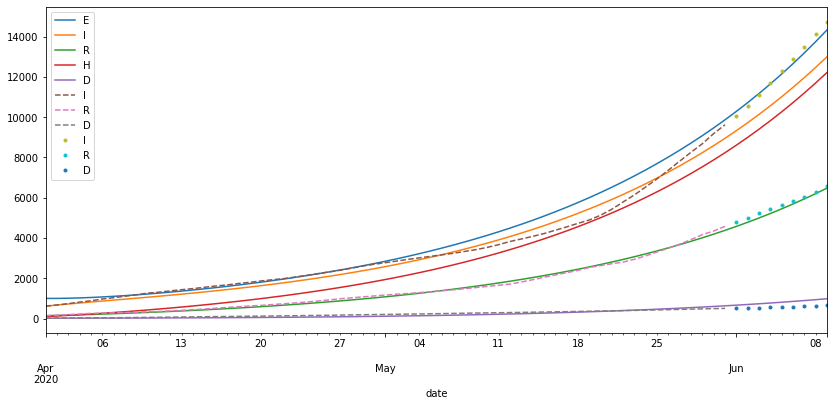

In [171]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")